In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

        age — возраст основного бенефициара;
        sex — пол страхового подрядчика;
        bmi — индекс массы тела (кгм), в идеале — от 18.5 до 24.9;
        children — количество детей, охваченных медицинской страховкой;
        smoker — является ли человек курящим;
        region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
        charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [3]:
print(data.shape)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [4]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [5]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

        age, bmi, children — числовые признаки;
        sex, smoker — бинарные категориальные переменные (две категории);
        region — множественные категориальные переменные (несколько категорий);
        charges — числовой целевой признак.

Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

        гистограммы/коробчатые диаграммы числовых признаков;
        столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
        диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

        smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
        sex — аналогично (0 — female, 1 — male);
        region — используем OneHot-кодирование (воспользуемся функцией get_dummies).


In [15]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [16]:
types = data.dtypes
types_list = list(types[types != object].index)
types_list

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'charges',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

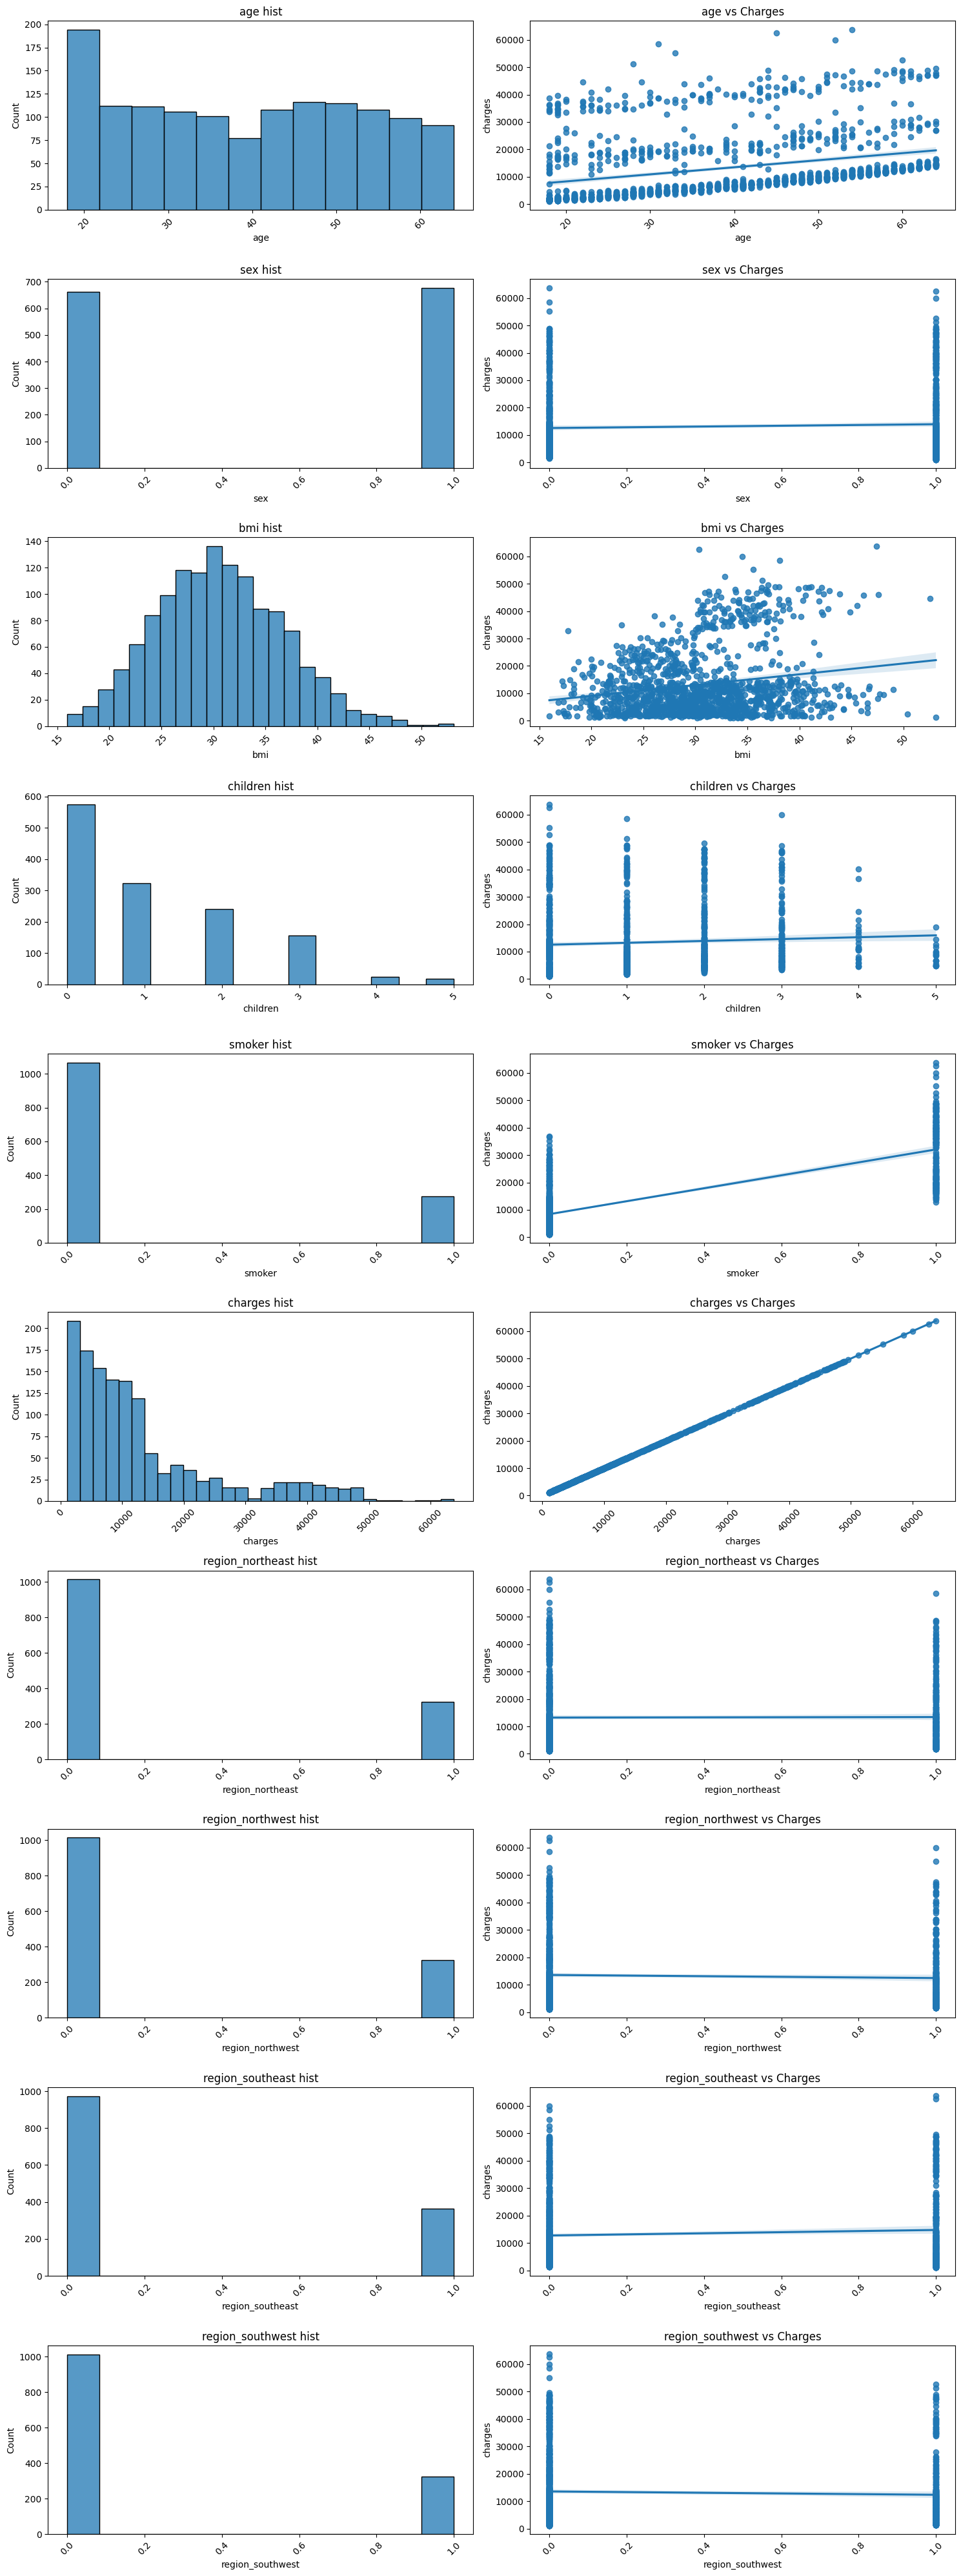

In [18]:
n = len(types_list)
fig, ax = plt.subplots(n, 2, figsize=(15, 40))
for i, feature in enumerate(types_list):
    histplot = sns.histplot(data=data, x=feature, ax=ax[i][0])
    histplot.set_title(f'{feature} hist')
    histplot.xaxis.set_tick_params(rotation=45)
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=ax[i][1])
    regplot.set_title(f'{feature} vs Charges')
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

<AxesSubplot: >

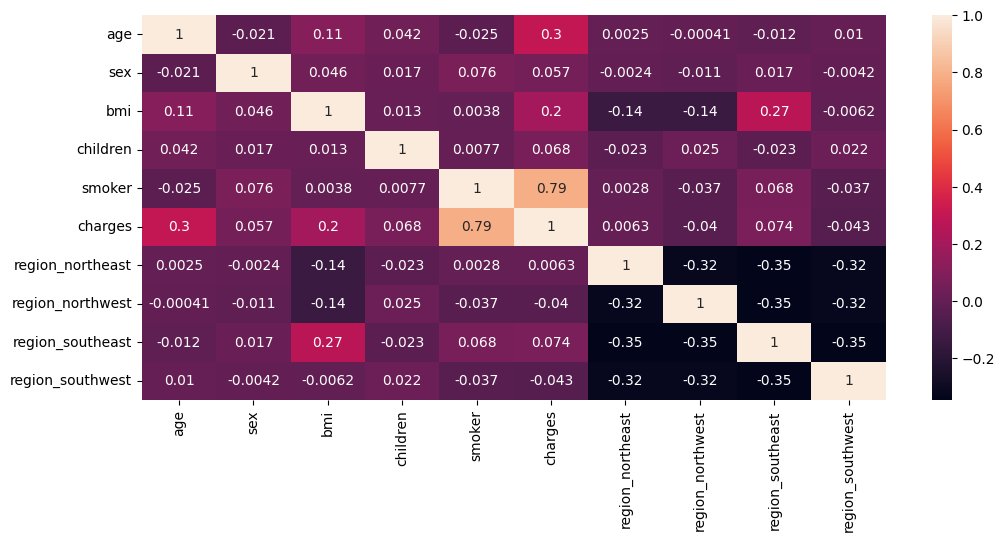

In [20]:
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data.corr(), annot=True)

In [19]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

Задание 6.1

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (1070, 9)
Test shape: (268, 9)


In [25]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(f'W0 (intercept) = {round(lr.intercept_, 2)}')

W0 (intercept) = -12390.8


Задание 6.3

С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики: , , . Не забудьте привести значение к процентам.

Значение округлите до трёх знаков после точки-разделителя, а значения и — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [28]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [29]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Train MAPE: 47


Задание 6.4

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: (без модуля).

In [41]:
test_pred_error

764       125.517976
887     -1796.571643
890     -7527.427762
1293     -152.784951
259      6777.118343
            ...     
109      7994.031168
575       461.399102
535     -1620.436882
543     22850.136498
846     -2445.885653
Name: charges, Length: 268, dtype: float64

Text(0.5, 0, 'Model')

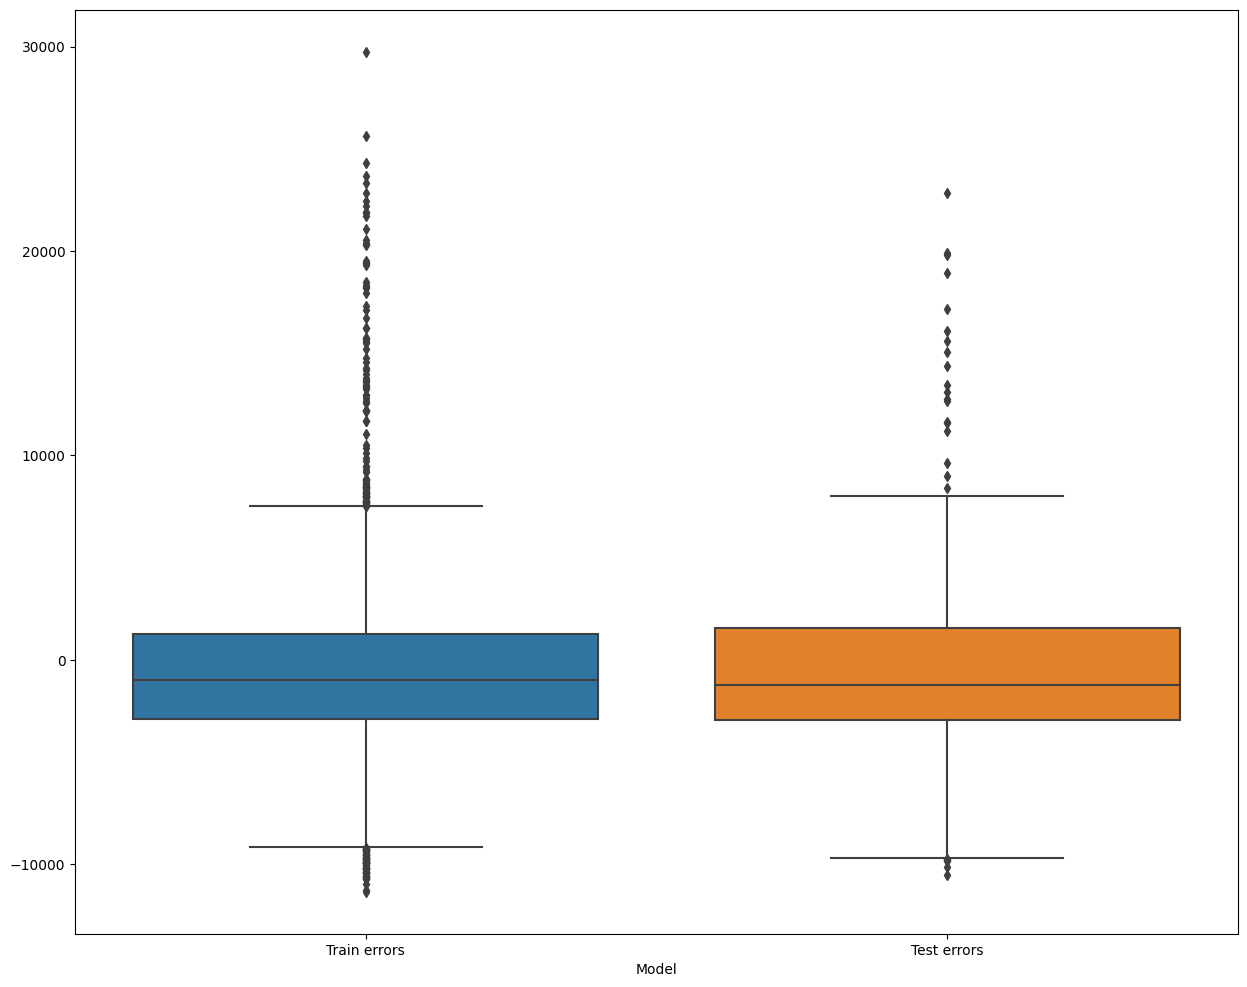

In [44]:
train_pred_error = y_train - y_train_pred
test_pred_error = y_test - y_test_pred
errors_df = pd.DataFrame({
    'Train errors': train_pred_error,
    'Test errors': test_pred_error
    })
fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(data=errors_df, ax=ax)
ax.set_xlabel('Model error')
ax.set_xlabel('Model')

Задание 6.5

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

Чему равно результирующее количество столбцов?

In [46]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print(X_train_scaled_poly.shape[1])


54


Задание 6.6

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики на тестовой выборке?

Значение округлите до трёх знаков после запятой.

In [47]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred_poly = lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred_poly, y_test, y_test_pred_poly)

Train R^2: 0.842
Train MAE: 2895
Train MAPE: 30


Test R^2: 0.866
Test MAE: 2738
Train MAPE: 30


In [52]:
lr_poly.coef_

array([-1.62442322e+15, -1.09587614e+16, -1.01191913e+15,  6.40805971e+14,
        3.86418228e+15, -1.29734418e+16, -1.52609005e+17,  4.07011365e+15,
       -6.26833662e+16,  8.26050000e+03,  8.34062500e+02,  1.28862500e+03,
       -1.52287500e+03,  1.95500000e+02,  1.62442322e+15,  1.62442322e+15,
        1.62442322e+15,  1.62442322e+15,  1.95161179e+16,  6.28359375e+02,
       -1.17904688e+03,  1.98914062e+02, -8.55735649e+15, -8.55735649e+15,
       -8.55735649e+15, -8.55735649e+15, -9.85518555e+03,  1.59951562e+03,
        5.48464746e+04,  1.01191913e+15,  1.01191913e+15,  1.01191913e+15,
        1.01191913e+15, -2.08000000e+03, -2.21600000e+03, -6.40805971e+14,
       -6.40805971e+14, -6.40805971e+14, -6.40805971e+14, -9.63435709e+15,
        5.77017482e+15,  5.77017482e+15,  5.77017482e+15,  5.77017482e+15,
       -2.22287308e+16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.17406833e+17,  0.00000000e+00,  0.00000000e+00, -3.92722863e+16,
        0.00000000e+00,  

Задание 6.8

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики , и на тестовой выборке?

Значение округлите до трёх знаков после запятой, а значения и до целого числа.

In [53]:
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred_poly_lasso = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly_lasso = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred_poly_lasso, y_test, y_test_pred_poly_lasso)

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2719
Train MAPE: 30


Задание 6.9

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики , и на тестовой выборке?

Значение округлите до трёх знаков после запятой, а значения и до целого числа.

In [55]:
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred_poly_ridge = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly_ridge = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred_poly_ridge, y_test, y_test_pred_poly_ridge)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Train MAPE: 31
